# Amphibole - plagioclase thermometer


*Jordan Lubbers, Penny Wieser*



There are two thermometers:
1. For assemblages where plagioclase and amphibole co-crystallize with quartz ($T_A$)
2. For assemblages where plagioclase and amphibole and plagioclase crystallize without quartz ($T_B$)

$$\large{T_A = \frac{-76.95 + 0.79P + Y_{ab} + 39.4{X_{Na}}^A + 22.4{X_K}^A + (41.5 - 2.89P){X_{Al}}^{M2}}{-0.0650 - R ln \left[ \frac{27{X_{\square}}^A{X_{Si}}^{T1}{X_{Ab}}^{plag}}{256{X_{Na}}^A{X_{Al}}^{T1}} \right] }} $$

- $Y_{ab}$:  0 for An > .5 and $12.01(1-X_{ab})^2 - 3kJ$ for An <.5


$$\large{T_B = \frac{78.44 + Y_{ab - an} - 33.6{X_{Na}}^A - (66.8 - 2.92P){X_{Al}}^{M2} + 78.5{X_{Al}}^{T1} + 9.4{X_{Na}}^A }{0.0721 - R ln \left[ \frac{27{X_{Na}}^{M4}{X_{Si}}^{T1}{X_{an}}^{plag}}{64{X_{Ca}}^{M4}{X_{Al}}^{T1}{X_{Ab}}^{plag}} \right] }} $$

- $Y_{ab-an}$: 3kJ for An > .5 and $12.01(2X_{ab} - 1)^2 + 3kJ$ for An <.5
- R is 0.0083144 kJ K$^{-1}$ 
- P is in kbar

This uses experiments from Sisson and Grove (1993) to check whether the thermometer was coded correctly or not. 

# Calculate amphibole and plag components
- you already have these coded but this reflects the most updated stuff I've done. I could not get the ```get_amphibole_23oxgens``` to produce a correct value for the number of cations. Otherwise, Should be really similar to the stuff you have already except for the ```get_amp_sites_ferric_ferrous```


In [21]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#%% Amphibole site calculations


def get_amp_components(df):

    # Removes the 'total column' from the list
    columns = list(df.columns)
    elements = []

    # List of columns you don't want to calculate the chemical formula for
    # here with amphibole it is the anions, water, and total columns
    # could expand this to other common things I suppose
    bad_elements = [
        "Total",
        "Cl",
        "H2O",
    ]

    # Remove the bad elements from your
    for element in bad_elements:
        for column in columns:
            if element in column:
                columns.remove(column)

    # dropping anything after the space This should get rid of anything
    # after the element name
    for column in columns:
        elements.append(column.split(" ")[0])

    # create new dataframe that is just the analyses without the total
    oxides = df.loc[:, columns]
    oxides.columns = elements
    mol_cations = np.zeros(oxides.shape)
    at_cations = np.zeros(oxides.shape)
    at_anions = np.zeros(oxides.shape)

    for i, element in zip(range(len(elements)), elements):
        if "Si" in element:
            mol_cations[:, i] = oxides[element] / (28.09 + (16 * 2))
            at_cations[:, i] = mol_cations[:, i] * 1
            at_anions[:, i] = mol_cations[:, i] * 2

        elif "Ti" in element:
            mol_cations[:, i] = oxides[element] / (47.87 + (16 * 2))
            at_cations[:, i] = mol_cations[:, i] * 1
            at_anions[:, i] = mol_cations[:, i] * 2
        elif "Al" in element:
            mol_cations[:, i] = oxides[element] / ((26.98 * 2) + (16 * 3))
            at_cations[:, i] = mol_cations[:, i] * 2
            at_anions[:, i] = mol_cations[:, i] * 3
        elif "Cr" in element:
            mol_cations[:, i] = oxides[element] / ((52 * 2) + (16 * 3))
            at_cations[:, i] = mol_cations[:, i] * 2
            at_anions[:, i] = mol_cations[:, i] * 3
        elif "Fe" in element:
            mol_cations[:, i] = oxides[element] / (55.85 + 16)
            at_cations[:, i] = mol_cations[:, i] * 1
            at_anions[:, i] = mol_cations[:, i] * 1

        elif "Mn" in element:
            mol_cations[:, i] = oxides[element] / (54.94 + 16)
            at_cations[:, i] = mol_cations[:, i] * 1
            at_anions[:, i] = mol_cations[:, i] * 1
        elif "Mg" in element:
            mol_cations[:, i] = oxides[element] / (24.31 + 16)
            at_cations[:, i] = mol_cations[:, i] * 1
            at_anions[:, i] = mol_cations[:, i] * 1
        elif "Ca" in element:
            mol_cations[:, i] = oxides[element] / (40.08 + 16)
            at_cations[:, i] = mol_cations[:, i] * 1
            at_anions[:, i] = mol_cations[:, i] * 1
        elif "Na" in element:
            mol_cations[:, i] = oxides[element] / ((23 * 2) + 16)
            at_cations[:, i] = mol_cations[:, i] * 2
            at_anions[:, i] = mol_cations[:, i] * 1
        elif "K" in element:
            mol_cations[:, i] = oxides[element] / ((39.1 * 2) + 16)
            at_cations[:, i] = mol_cations[:, i] * 2
            at_anions[:, i] = mol_cations[:, i] * 1

    # new column names to drop the amp. Can make this more flexible or we can just force the formatting
    # of the output inside the function
    newnames = []
    for name in oxides.columns.tolist():
        newnames.append(name.split("_")[0])

    # dataframes form molecular proportion of cations, atomic fraction cations, atomic fraction anions
    mol_cations = pd.DataFrame(mol_cations, columns=newnames, index=oxides.index)
    at_cations = pd.DataFrame(at_cations, columns=newnames, index=oxides.index)
    at_anions = pd.DataFrame(at_anions, columns=newnames, index=oxides.index)

    # ideal oxygens
    n_oxygens = 23

    # dataframes for cations and anions normalized to 23 oxygens
    norm_anions = (at_anions * n_oxygens).div(
        at_anions.sum(axis="columns"), axis="rows"
    )
    norm_cations = (at_cations * n_oxygens).div(
        at_anions.sum(axis="columns"), axis="rows"
    )

    return norm_cations, norm_anions

# from amphibole.py
def get_amp_sites(amp_apfu_df):
    """
    get_amp_sites takes generalized atom per formula unit calculations from
    calculate_amphibole_23oxygens and puts them in the proper cation sites 
    according to Leake et al., 1997. 

    Parameters
    ----------
    amp_apfu_df : pandas DataFrame
        This is the dataframe output from calculate_amphibole_23oxygens. You should
        not have to modify this dataframe at all. 
        

    Returns
    -------
    sites_df : pandas DataFrame
        a samples by cation sites dimension dataframe where each column corresponds
        to a cation site in amphibole. The suffix at the end corresponds to which site
        the cation is in:
            T = tetrahedral sites (8 total)
            C = octahedral sites (5 total)
            B  = M4 sites (2 total)
            A = A site (0 - 1 total)

    """
    # new column names to drop the amp_cat_23ox. Can make this more flexible or we can just force the formatting
    # of the output inside the function. Mostly I didnt want to type it out a bunch so we can omit this little
    # loop if we want to formalize things
    newnames = []
    for name in amp_apfu_df.columns.tolist():
        newnames.append(name.split("_")[0])

    norm_cations = amp_apfu_df.copy()
    norm_cations.columns = newnames

    samples = norm_cations.index.tolist()

    # containers to fill later
    Si_T = np.empty(len(samples))
    Al_T = np.empty(len(samples))
    Al_C = np.empty(len(samples))
    Ti_C = np.empty(len(samples))
    Mg_C = np.empty(len(samples))
    Fe_C = np.empty(len(samples))
    Mn_C = np.empty(len(samples))
    Mg_B = np.empty(len(samples))
    Fe_B = np.empty(len(samples))
    Mn_B = np.empty(len(samples))
    Na_B = np.empty(len(samples))
    Ca_B = np.empty(len(samples))
    Na_A = np.empty(len(samples))
    K_A = np.empty(len(samples))
    Cr_C = np.empty(len(samples))

    for sample, i in zip(samples, range(len(samples))):
        # these are all the cations that have no site ambiguity
        Si_T[i] = norm_cations.loc[sample, "SiO2"]
        K_A[i] = norm_cations.loc[sample, "K2O"]
        Ti_C[i] = norm_cations.loc[sample, "TiO2"]
        Ca_B[i] = norm_cations.loc[sample, "CaO"]

        if "Cr2O3" in norm_cations.columns:

            Cr_C[i] = norm_cations.loc[sample, "Cr2O3"]
        else:

            Cr_C[i] = 0

        # site ambiguous cations. Follows Leake et al., (1997) logic
        if Si_T[i] + norm_cations.loc[sample, "Al2O3"] > 8:
            Al_T[i] = 8 - norm_cations.loc[sample, "SiO2"]
            Al_C[i] = (
                norm_cations.loc[sample, "SiO2"] + norm_cations.loc[sample, "Al2O3"] - 8
            )
        else:
            Al_T[i] = norm_cations.loc[sample, "Al2O3"]
            Al_C[i] = 0

        if Al_C[i] + Ti_C[i] + Cr_C[i] + norm_cations.loc[sample, "MgO"] > 5:
            Mg_C[i] = 5 - Al_C[i] + Ti_C[i] + Cr_C[i]
            Mg_B[i] = Al_C[i] + Ti_C[i] + Cr_C[i] + norm_cations.loc[sample, "MgO"] - 5
        else:
            Mg_C[i] = norm_cations.loc[sample, "MgO"]
            Mg_B[i] = 0

        if Al_C[i] + Ti_C[i] + Cr_C[i] + Mg_C[i] > 5:
            Fe_C[i] = 0
            Fe_B[i] = norm_cations.loc[sample, "FeOt"]
        else:
            Fe_C[i] = 5 - (Al_C[i] + Ti_C[i] + Cr_C[i] + Mg_C[i])
            Fe_B[i] = norm_cations.loc[sample, "FeOt"] - Fe_C[i]

        if Al_C[i] + Ti_C[i] + Cr_C[i] + Mg_C[i] + Fe_C[i] > 5:
            Mn_C[i] = 0
            Mn_B[i] = norm_cations.loc[sample, "MnO"]
        else:
            Mn_C[i] = 5 - (Al_C[i] + Ti_C[i] + Cr_C[i] + Mg_C[i] + Fe_C[i])
            Mn_B[i] = norm_cations.loc[sample, "MnO"] - Mn_C[i]

        if Mg_B[i] + Fe_B[i] + Mn_B[i] + Ca_B[i] > 2:
            Na_B[i] = 0
            Na_A[i] = norm_cations.loc[sample, "Na2O"]
        else:
            Na_B[i] = 2 - (Mg_B[i] + Fe_B[i] + Mn_B[i] + Ca_B[i])
            Na_A[i] = norm_cations.loc[sample, "Na2O"] - Na_B[i]

    # making the dataframe for the output
    site_vals = np.array(
        [
            Si_T,
            Al_T,
            Al_C,
            Ti_C,
            Mg_C,
            Fe_C,
            Mn_C,
            Cr_C,
            Mg_B,
            Fe_B,
            Mn_B,
            Na_B,
            Ca_B,
            Na_A,
            K_A,
        ]
    )
    sites_df = pd.DataFrame(
        site_vals.T,
        columns=[
            "Si_T",
            "Al_T",
            "Al_C",
            "Ti_C",
            "Mg_C",
            "Fe_C",
            "Mn_C",
            "Cr_C",
            "Mg_B",
            "Fe_B",
            "Mn_B",
            "Na_B",
            "Ca_B",
            "Na_A",
            "K_A",
        ],
        index=amp_apfu_df.index,
    )
    return sites_df


# this has been updated from what is in amphibole.py and includes an argument
# for "mutch" or "hb"
def get_amp_components_ferric_ferrous(sites_df, norm_cations, method):
    """
    get_amp_components_ferric_ferrous calculates the Fe3+ and Fe2+ apfu values of 
    amphibole and adjusts the generic stoichiometry such that charge balance is 
    maintained. This is based off the "f parameters" listed in Holland and Blundy
    (1994). 

    Parameters
    ----------
    sites_df : pandas DataFrame
        output from the get_amp_sites function. you do not need to modify this at all
    norm_cations : pandas DataFrame
        This is the dataframe output from calculate_amphibole_23oxygens. You should
        not have to modify this dataframe at all. 
    method : string
            Whether you use the method of holland and blundy 1994 or mutch 2016
        

    Returns
    -------
    norm_cations_hb : pandas DataFrame
        amphibole apfu values for each cation, however two things are different:
            1) FeOt is replaced by individual Fe2O3 and FeO columns
            2) all apfu values from the generic mineral recalculation have been
                adjusted by the "f" parameter from Holland and Blundy (1994)
                to maintain charge balance and stoichiometry

    """
    # A group
    f1 = 16 / sites_df.sum(axis="columns")
    f2 = 8 / sites_df["Si_T"]
    f3 = 15 / (
        sites_df.sum(axis="columns")
        - sites_df["K_A"]
        - (sites_df["Na_A"] + sites_df["Na_B"])
        + sites_df["Mn_B"]
    )
    f4 = 2 / sites_df["Ca_B"]
    f5 = 1
    fa = pd.DataFrame({"f1": f1, "f2": f2, "f3": f3, "f4": f4, "f5": f5,})

    # B group
    f6 = 8 / (sites_df["Si_T"] + sites_df["Al_T"] + sites_df["Al_C"])
    f7 = 15 / (sites_df.sum(axis="columns") - sites_df["K_A"])
    f8 = 12.9 / (
        sites_df.sum(axis="columns")
        - (sites_df["Na_A"] + sites_df["K_A"])
        - (sites_df["Mn_C"] + sites_df["Mn_B"])
        - sites_df["Ca_B"]
    )
    f9 = 36 / (
        46 - (sites_df["Al_T"] + sites_df["Al_C"]) - sites_df["Si_T"] - sites_df["Ti_C"]
    )
    f10 = 46 / ((sites_df["Fe_C"] + sites_df["Fe_B"]) + 46)
    fb = pd.DataFrame({"f6": f6, "f7": f7, "f8": f8, "f9": f9, "f10": f10,})

    if method == "hb":

        f_ave = (fa.min(axis="columns") + fb.max(axis="columns")) / 2

    elif method == "mutch":

        f_ave = (2 / 3) * fa.min(axis="columns") + (1 / 3) * fb.max(axis="columns")

    norm_cations_hb = norm_cations.multiply(f_ave, axis="rows")
    norm_cations_hb["Fe2O3"] = 46 * (1 - f_ave)
    norm_cations_hb["FeO"] = norm_cations_hb["FeOt"] - norm_cations_hb["Fe2O3"]
    newnames = []

    for name in norm_cations_hb.columns.tolist():
        newnames.append(name.split("_")[0])

    norm_cations_hb.columns = newnames

    return norm_cations_hb, fa, fb

#This has been updated from what is in amphibole.py
def get_amp_sites_ferric_ferrous(norm_cations_hb):
    """
    get_amp_sites_ferric_ferrous is very similar to get_amp_sites, however it now
    incorporates the newly calculated Fe2O3 and FeO apfu values such that all 
    Fe2O3 gets incorporated into the octahedral sites before any FeO. For more 
    information see Leake et al., 1997 Appendix A.

    Parameters
    ----------
    amp_apfu_df :pandas DataFrame
        amphibole apfu values for each cation, now reflecting Fe2O3 and FeO 
        values. This is the output from amp_components_ferric_ferrous and does 
        not need to be modified at all.

    Returns
    -------
    sites_df : pandas DataFrame
    a samples by cation sites dimension dataframe where each column corresponds
        to a cation site in amphibole. The suffix at the end corresponds to which site
        the cation is in:
            T = tetrahedral sites (8 total)
            C = octahedral sites (5 total)
            B  = M4 sites (2 total)
            A = A site (0 - 1 total)
        See Leake et al., 1997 for a discussion on cation site prioritization

    """
    samples = norm_cations_hb.index.tolist()
    Si_T = np.empty(len(samples))
    Al_T = np.empty(len(samples))
    Al_D = np.empty(len(samples))
    Ti_D = np.empty(len(samples))
    Mg_D = np.empty(len(samples))
    Fe3_D = np.empty(len(samples))
    Fe2_B = np.empty(len(samples))
    Mn_C = np.empty(len(samples))
    Mg_C = np.empty(len(samples))
    Fe2_C = np.empty(len(samples))
    Mn_B = np.empty(len(samples))
    Na_B = np.empty(len(samples))
    Ca_B = np.empty(len(samples))
    Na_A = np.empty(len(samples))
    K_A = np.empty(len(samples))
    Cr_D = np.empty(len(samples))
    Fe3_C = np.empty(len(samples))

    for sample, i in zip(samples, range(len(samples))):
        Si_T[i] = norm_cations_hb.loc[sample, "SiO2"]
        K_A[i] = norm_cations_hb.loc[sample, "K2O"]
        Ti_D[i] = norm_cations_hb.loc[sample, "TiO2"]
        Ca_B[i] = norm_cations_hb.loc[sample, "CaO"]

        if "Cr2O3" in norm_cations_hb.columns:

            Cr_D[i] = norm_cations_hb.loc[sample, "Cr2O3"]
        else:
            Cr_D[i] = 0

        Fe3_D[i] = norm_cations_hb.loc[sample, "Fe2O3"]

        if Si_T[i] + norm_cations_hb.loc[sample, "Al2O3"] > 8:
            Al_T[i] = 8 - norm_cations_hb.loc[sample, "SiO2"]
            Al_D[i] = (
                norm_cations_hb.loc[sample, "SiO2"]
                + norm_cations_hb.loc[sample, "Al2O3"]
                - 8
            )
        else:
            Al_T[i] = norm_cations_hb.loc[sample, "Al2O3"]
            Al_D[i] = 0

        if (
            Al_D[i] + Ti_D[i] + Cr_D[i] + Fe3_D[i] + norm_cations_hb.loc[sample, "MgO"]
            > 2
        ):
            Mg_D[i] = 2 - (Al_D[i] + Ti_D[i] + Cr_D[i] + Fe3_D[i])
            Mg_C[i] = norm_cations_hb.loc[sample, "MgO"] - Mg_D[i]
        else:
            Mg_D[i] = norm_cations_hb.loc[sample, "MgO"]
            Mg_C[i] = 0

        if Mg_C[i] + norm_cations_hb.loc[sample, "FeO"] > 3:
            Fe2_C[i] = 3 - Mg_C[i]
            Fe2_B[i] = norm_cations_hb.loc[sample, "FeO"] - Fe2_C[i]
        else:
            Fe2_C[i] = norm_cations_hb.loc[sample, "FeO"]
            Fe2_B[i] = 0

        if Mg_C[i] + Fe2_C[i] > 3:
            Mn_C[i] = 0
            Mn_B[i] = norm_cations_hb.loc[sample, "MnO"]
        else:
            Mn_C[i] = 3 - (Mg_C[i] + Fe2_C[i])
            Mn_B[i] = norm_cations_hb.loc[sample, "MnO"] - Mn_C[i]

        if Fe2_B[i] + Mn_B[i] + Ca_B[i] > 2:
            Na_B[i] = 0
            Na_A[i] = norm_cations_hb.loc[sample, "Na2O"]
        else:
            Na_B[i] = 2 - (Fe2_B[i] + Mn_B[i] + Ca_B[i])
            Na_A[i] = norm_cations_hb.loc[sample, "Na2O"] - Na_B[i]

    site_vals = np.array(
        [
            Si_T,
            Al_T,
            Al_D,
            Ti_D,
            Mg_D,
            Fe3_D,
            Cr_D,
            Fe2_C,
            Mn_C,
            Mg_C,
            Fe2_B,
            Mn_B,
            Na_B,
            Ca_B,
            Na_A,
            K_A,
        ]
    )
    sites_df = pd.DataFrame(
        site_vals.T,
        columns=[
            "Si_T",
            "Al_T",
            "Al_D",
            "Ti_D",
            "Mg_D",
            "Fe3_D",
            "Cr_D",
            "Fe2_C",
            "Mn_C",
            "Mg_C",
            "Fe2_B",
            "Mn_B",
            "Na_B",
            "Ca_B",
            "Na_A",
            "K_A",
        ],
        index=norm_cations_hb.index,
    )
    return sites_df


#%% General mineral recalculation. Check jupyter notebook
def mineral_formula_calc(df, n_oxygens, mineral, normalized):

    """
    mineral_formula_calc is a function that calculates the stoichiometry for a mineral based on a set of major
    element oxide analyses as described by Deer et al., 1966 Appendix 1
    
    Inputs:
    df : pandas dataframe object of major element analyses. Column headers must have the the element somewhere in the name
    
    ** if a column containing 'Total' in the name exists, it will be removed so that only the individual analyses are 
    present
    ** your dataframe should have a column that pertains to sample, analysis number, etc. This will be set as the index
    of the dataframe so that chemical formulas can be accessed easily upon calculation
    
    EXAMPLE OF INPUT DATAFRAME:
    |sample|SiO2|TiO2|Al2O3|Cr2O3|FeO|BaO|SrO|MnO|CaO|Na2O|K2O|NiO|Total| <---- currently supported elements
    
    
    n_oxygens : number of ideal oxygens in the chemical formula (e.g., for feldspars this would be 8)
    
    mineral : 'feldspar','olivine','pyroxene'
    if 'pyroxene' is chosen, the function will calculate the proportions of Fe2+ and Fe3+ based off stoichiometry and charge
    balance as described by Droop 1987. If 'feldspar', all Fe is assumed to be Fe3+. If 'olivine', all Fe is assumed to be 2+
    
    normalized: boolean 
    if True, will normalize your geochemical analyses. If false, mineral formulas will be calculated using 
    raw geochemical data
    
    
    Returns:
    norm_cations: pandas dataframe object that contains the calculated number of cations in the chemical formula
    normalized to the amount of ideal oxygens specified by 'n_oxygens'. 
    
    
    
    """

    data = df.copy()
    data.fillna(0, inplace=True)
    # if index is not None:

    #     data.set_index(index,inplace = True)
    # else:
    #     data.index = np

    # Removes the 'total column' from the list
    columns = list(data.columns)
    elements = []
    for column in columns:
        if "Total" in column:
            columns.remove(column)

    # can make this a delimeter variable for the user to choose from
    # dropping anything after the underscore
    for column in columns:

        if "Si" in column:
            elements.append(column.split("_")[0])
        if "Ti" in column:
            elements.append(column.split("_")[0])
        if "Al" in column:
            elements.append(column.split("_")[0])
        if "Cr" in column:
            elements.append(column.split("_")[0])
        if "Fe" in column:
            elements.append(column.split("_")[0])
        if "Ba" in column:
            elements.append(column.split("_")[0])
        if "Sr" in column:
            elements.append(column.split("_")[0])
        if "Mn" in column:
            elements.append(column.split("_")[0])
        if "Mg" in column:
            elements.append(column.split("_")[0])
        if "Na" in column:
            elements.append(column.split("_")[0])
        if "K" in column:
            elements.append(column.split("_")[0])
        if "Ca" in column:
            elements.append(column.split("_")[0])
        if "Ni" in column:
            elements.append(column.split("_")[0])
        if "Cl" in column:
            elements.append(column.split("_")[0])
        if "P2O5" in column:
            elements.append(column.split("_")[0])

    # create new dataframe that is just the analyses without the total
    oxides = data.loc[:, columns]
    oxides.columns = elements

    if normalized == True:

        # normalize the wt%
        oxides_normalized = 100 * (oxides.div(oxides.sum(axis="columns"), axis="rows"))
    elif normalized == False:
        oxides_normalized = oxides.copy()

    # create an array filled with zeros such that it is the same shape of our input
    # data
    mol_cations = np.zeros(oxides_normalized.shape)

    # these loops are saying that: for each element in my list of elements (e.g., columns)
    # check to see if the given string (e.g., Si) is in it. If it is, then populate that column
    # of the array with the appropriate math

    # Here we call on the mendeleev package module 'element' to get the mass from a given element
    # e.g.(el(element).mass)
    for i, element in zip(range(len(elements)), elements):
        if "Si" in element:
            mol_cations[:, i] = oxides_normalized[element] / (28.09 + (16 * 2))
        elif "Ti" in element:
            mol_cations[:, i] = oxides_normalized[element] / (47.87 + (16 * 2))
        elif "Al" in element:
            mol_cations[:, i] = (2 * oxides_normalized[element]) / (
                (26.98 * 2) + (16 * 3)
            )
        elif "Cr" in element:
            mol_cations[:, i] = (2 * oxides_normalized[element]) / ((52 * 2) + (16 * 3))
        elif "Fe" in element:
            mol_cations[:, i] = oxides_normalized[element] / (55.85 + 16)
        elif "Ba" in element:
            mol_cations[:, i] = oxides_normalized[element] / (137.33 + 16)
        elif "Sr" in element:
            mol_cations[:, i] = oxides_normalized[element] / (87.62 + 16)
        elif "Mn" in element:
            mol_cations[:, i] = oxides_normalized[element] / (54.94 + 16)
        elif "Mg" in element:
            mol_cations[:, i] = oxides_normalized[element] / (24.31 + 16)
        elif "Ca" in element:
            mol_cations[:, i] = oxides_normalized[element] / (40.08 + 16)
        elif "Na" in element:
            mol_cations[:, i] = (2 * oxides_normalized[element]) / ((23 * 2) + 16)
        elif "K" in element:
            mol_cations[:, i] = (2 * oxides_normalized[element]) / ((39.1 * 2) + 16)
        elif "Ni" in element:
            mol_cations[:, i] = oxides_normalized[element] / (58.69 + 16)

    mol_cations = pd.DataFrame(mol_cations, columns=elements)

    # Calculating the number of oxygens per cation in the formula
    mol_oxygens = np.zeros(mol_cations.shape)

    for i, element in zip(range(len(elements)), elements):
        if "Si" in element:
            mol_oxygens[:, i] = mol_cations[element] * 2
        elif "Ti" in element:
            mol_oxygens[:, i] = mol_cations[element] * 2
        elif "Al" in element:
            mol_oxygens[:, i] = mol_cations[element] * (3 / 2)
        elif "Cr" in element:
            mol_oxygens[:, i] = mol_cations[element] * (3 / 2)
        elif "Fe" in element:
            mol_oxygens[:, i] = mol_cations[element] * 1
        elif "Ba" in element:
            mol_oxygens[:, i] = mol_cations[element] * 1
        elif "Sr" in element:
            mol_oxygens[:, i] = mol_cations[element] * 1
        elif "Mn" in element:
            mol_oxygens[:, i] = mol_cations[element] * 1
        elif "Mg" in element:
            mol_oxygens[:, i] = mol_cations[element] * 1
        elif "Ca" in element:
            mol_oxygens[:, i] = mol_cations[element] * 1
        elif "Na" in element:
            mol_oxygens[:, i] = mol_cations[element] * (1 / 2)
        elif "K" in element:
            mol_oxygens[:, i] = mol_cations[element] * (1 / 2)
        elif "Ni" in element:
            mol_oxygens[:, i] = mol_cations[element] * 1

    mol_oxygens = pd.DataFrame(mol_oxygens, columns=elements)

    # number of oxygens per cation, normalized to the ideal number of oxygens specified above
    norm_oxygens = (mol_oxygens * n_oxygens).div(
        mol_oxygens.sum(axis="columns"), axis="rows"
    )

    # calculate the mole cations of each oxide normalized to the number of ideal oxygens
    norm_cations = np.zeros(norm_oxygens.shape)

    for i, element in zip(range(len(elements)), elements):
        if "Si" in element:
            norm_cations[:, i] = norm_oxygens[element] / 2
        elif "Ti" in element:
            norm_cations[:, i] = norm_oxygens[element] / 2
        elif "Al" in element:
            norm_cations[:, i] = norm_oxygens[element] / (3 / 2)
        elif "Cr" in element:
            norm_cations[:, i] = norm_oxygens[element] / (3 / 2)
        elif "Fe" in element:
            norm_cations[:, i] = norm_oxygens[element]
        elif "Ba" in element:
            norm_cations[:, i] = norm_oxygens[element]
        elif "Sr" in element:
            norm_cations[:, i] = norm_oxygens[element]
        elif "Mn" in element:
            norm_cations[:, i] = norm_oxygens[element]
        elif "Mg" in element:
            norm_cations[:, i] = norm_oxygens[element]
        elif "Ca" in element:
            norm_cations[:, i] = norm_oxygens[element]
        elif "Na" in element:
            norm_cations[:, i] = norm_oxygens[element] / (1 / 2)
        elif "K" in element:
            norm_cations[:, i] = norm_oxygens[element] / (1 / 2)
        elif "Ni" in element:
            norm_cations[:, i] = norm_oxygens[element]

    cations = []
    # Get the cations by taking the first two characters
    [cations.append(element[:2]) for element in elements]

    # since some elements are only one letter (e.g., K) this
    # strips the number from it

    r = re.compile("([a-zA-Z]+)([0-9]+)")
    for i in range(len(cations)):

        m = r.match(cations[i])
        if m != None:
            cations[i] = m.group(1)

    norm_cations = pd.DataFrame(norm_cations, columns=cations)
    norm_cations[data.index.name] = data.index.tolist()
    norm_cations["Total_cations"] = norm_cations.sum(axis="columns")

    if mineral == "pyroxene":
        # ideal cations
        T = 4

        # calculated cations based on oxide measurements
        # S = norm_cations['Total_cations']

        # step 2 and 3 from Droop 1987
        norm_cations.loc[norm_cations["Total_cations"] > T, "Fe_3"] = (
            2 * n_oxygens * (1 - (T / norm_cations["Total_cations"]))
        )
        norm_cations.loc[norm_cations["Total_cations"] <= T, "Fe_3"] = 0

        # step 4 from Droop 1987
        norm_cations.set_index(data.index.name, inplace=True)

        ts = T / norm_cations["Total_cations"].to_numpy()
        norm_cations = norm_cations * ts[:, np.newaxis]

        norm_cations["Fe_2"] = norm_cations["Fe"] - norm_cations["Fe_3"]

    else:

        norm_cations.set_index(data.index.name, inplace=True)

    return norm_cations

# Import data

In [23]:
import Thermobar as pt
a=pt.calculate_cat_fractions_plagioclase(plag_comps=plags)
a['Ab_Plag'].to_clipboard(excel=True)

# Get amphibole components and sites
- uses the functions defined above

In [24]:
# get the cations normalized to 23 oxygens
amp_cations, amp_anions = get_amp_components(amphs)

# get the ideal site allocations
amp_sites = get_amp_sites(amp_cations)


# get cations normalized to 23 oxygens and take Fe2/Fe3 into account
# using Holland and Blundy (1994)
amp_cations_fe, fa, fb = get_amp_components_ferric_ferrous(
    amp_sites, amp_cations, "mutch"
)


# get the ideal site allocations based taking Fe2/Fe3 into account
amp_sites_fe = get_amp_sites_ferric_ferrous(amp_cations_fe)
amp_sites_fe

,Si_T,Al_T,Al_D,Ti_D,Mg_D,Fe3_D,Cr_D,Fe2_C,Mn_C,Mg_C,Fe2_B,Mn_B,Na_B,Ca_B,Na_A,K_A
sample,,,,,,,,,,,,,,,,
87S35a3,5.881133,2.118867,0.265631,0.330490,0.867861,0.536018,0.0,0.701406,0.0,2.298594,0.043573,0.015912,0.098014,1.842501,0.669449,0.084802
87S35a11,5.846542,2.153458,0.201360,0.300610,0.835815,0.662215,0.0,0.726292,0.0,2.273708,0.012036,0.017420,0.081720,1.888824,0.678550,0.091832
87S35a10,6.028891,1.971109,0.334547,0.348149,1.045677,0.271627,0.0,1.064434,0.0,1.935566,0.031293,0.019784,0.103212,1.845711,0.680592,0.091257
87S35a13,5.976949,2.023051,0.273864,0.296501,0.911432,0.518203,0.0,1.006527,0.0,1.993473,0.056359,0.023405,0.112688,1.807548,0.665326,0.085345
85S52b14,6.126963,1.873037,0.290108,0.298972,1.038054,0.372866,0.0,0.785341,0.0,2.214659,0.050316,0.018360,0.104252,1.827072,0.565198,0.151173
85S52b9,6.076373,1.923627,0.310300,0.285177,0.981448,0.423075,0.0,0.832704,0.0,2.167296,0.050977,0.024510,0.110773,1.813741,0.595929,0.134741
82667,6.128842,1.871158,0.217312,0.151880,0.884172,0.746637,0.0,0.333593,0.0,2.666407,0.078521,0.017223,0.083524,1.820732,0.620271,0.066704
82-661A,5.949626,2.050374,0.275909,0.189669,0.760132,0.774290,0.0,0.453013,0.0,2.546987,0.061833,0.017084,0.099640,1.821444,0.654312,0.066164


# Plag components

In [25]:
plag_cations = mineral_formula_calc(
    plags.loc[:, "SiO2_Plag":"Total_Plag"],
    n_oxygens=8,
    mineral="plag",
    normalized=False,
)
plag_cations.head()

<ipython-input-21-d3785fbcbea3>:715: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  norm_cations["Total_cations"] = norm_cations.sum(axis="columns")


,Si,Al,Fe,Mg,Ca,Na,K,Total_cations
sample,,,,,,,,
87S35a3,2.142545,1.845494,0.029482,0.005460,0.838831,0.142873,0.002920,5.007605
87S35a11,2.182456,1.790950,0.030421,0.006177,0.818973,0.182070,0.004112,5.015159
87S35a10,2.224430,1.757019,0.022386,0.002752,0.791199,0.195015,0.003533,4.996334
87S35a13,2.317018,1.663320,0.022462,0.004750,0.692619,0.298242,0.004065,5.002476
85S52b14,2.172491,1.796319,0.027118,0.006905,0.848741,0.149051,0.006501,5.007125


# Piece by piece thermometer
- Holland and Blundy 1994 A and B. 
*I can really only test thermometer B, as the experimental data I have from Sisson and Grove 1993 downloaded does not have quartz in its phase assemblage*

## individual components that go into thermometer

In [26]:
Pgpa = 0.2  # GPa
thermometer = "B"
# thermodynamic parameters
R = 0.0083144  # kJ/K
P = Pgpa * 10  # kbar

#Anorthite and albite components
Ab = (
    plag_cations["Na"] / (plag_cations["Na"] + plag_cations["Ca"] + plag_cations["K"])
).to_numpy()
An = (
    plag_cations["Ca"] / (plag_cations["Na"] + plag_cations["Ca"] + plag_cations["K"])
).to_numpy()

plag_cations["An"] = An
plag_cations["Ab"] = Ab



# Calculating Yab for Thermometer A
Y = np.empty(An.shape)

# Yab-an parameters for each thermometer
for i in range(len(An)):
    # Calculating Yab for Thermometer A

    if thermometer == "A":

        if Ab[i] > 0.5:
            Y[i] = 0
        else:
            Y[i] = 12.0 * (1 - Ab[i]) ** 2 - 3

    elif thermometer == "B":

        # Calculating Yab-an for Thermometer B
        if Ab[i] > 0.5:
            Y[i] = 3
        else:
            Y[i] = 12.0 * ((2 * Ab[i]) - 1) + 3
    else:
        raise Exception(
            'This alphabet is only two letters long. Please choose "A" or "B" for your thermometer'
        )


plag_cations["Y"] = Y
plag_cations

,Si,Al,Fe,Mg,Ca,Na,K,Total_cations,An,Ab,Y
sample,,,,,,,,,,,
87S35a3,2.142545,1.845494,0.029482,0.005460,0.838831,0.142873,0.002920,5.007605,0.851930,0.145104,-5.517500
87S35a11,2.182456,1.790950,0.030421,0.006177,0.818973,0.182070,0.004112,5.015159,0.814773,0.181136,-4.652733
87S35a10,2.224430,1.757019,0.022386,0.002752,0.791199,0.195015,0.003533,4.996334,0.799395,0.197035,-4.271149
87S35a13,2.317018,1.663320,0.022462,0.004750,0.692619,0.298242,0.004065,5.002476,0.696151,0.299763,-1.805687
85S52b14,2.172491,1.796319,0.027118,0.006905,0.848741,0.149051,0.006501,5.007125,0.845114,0.148413,-5.438076
85S52b9,2.194519,1.785779,0.024190,0.006159,0.806769,0.183324,0.007029,5.007768,0.809098,0.183853,-4.587527
82667,2.156848,1.822143,0.017806,0.004830,0.853014,0.152519,0.002362,5.009521,0.846333,0.151324,-5.368224
82-661A,2.186003,1.783404,0.026395,0.004843,0.830502,0.179929,0.002368,5.013444,0.820007,0.177655,-4.736283


In [27]:
# cummingtonite substitution

cm = (
    amp_sites_fe["Si_T"]
    + (amp_sites_fe["Al_T"] + amp_sites_fe["Al_D"])
    + amp_sites_fe["Ti_D"]
    + amp_sites_fe["Fe3_D"]
    + (amp_sites_fe["Fe2_C"] + amp_sites_fe["Fe2_B"])
    + (amp_sites_fe["Mg_D"] + amp_sites_fe["Mg_C"])
    + amp_sites_fe["Mn_C"]
    + amp_sites_fe["Mn_B"]
    - 13
)


# site terms for the thermometer
Si_T1 = (amp_sites_fe["Si_T"] - 4) / 4

Al_T1 = (8 - amp_sites_fe["Si_T"]) / 4

Al_M2 = (amp_sites_fe["Al_T"] + amp_sites_fe["Al_D"] + amp_sites_fe["Si_T"] - 8) / 2

K_A = amp_sites_fe["K_A"]

box_A = (
    3
    - amp_sites_fe["Ca_B"]
    - (amp_sites_fe["Na_B"] + amp_sites_fe["Na_A"])
    - amp_sites_fe["K_A"]
    - cm
)

Na_A = amp_sites_fe["Ca_B"] + amp_sites_fe["Na_B"] + amp_sites_fe["Na_A"] + cm - 2

Na_M4 = (2 - amp_sites_fe["Ca_B"] - cm) / 2

Ca_M4 = amp_sites_fe["Ca_B"] / 2


# turn it into a dataframe
hbl_plag_params = pd.DataFrame(
    {
        "Si_T1": Si_T1,
        "Al_T1": Al_T1,
        "Al_M2": Al_M2,
        "K_A": K_A,
        "box_A": box_A,
        "Na_A": Na_A,
        "Na_M4": Na_M4,
        "Ca_M4": Ca_M4,
    }
)
# put the index back in for the sample labels
hbl_plag_params.index = amphs.index
hbl_plag_params

,Si_T1,Al_T1,Al_M2,K_A,box_A,Na_A,Na_M4,Ca_M4
sample,,,,,,,,
87S35a3,0.470283,0.529717,0.132816,0.084802,0.245749,0.669449,0.049007,0.921251
87S35a11,0.461636,0.538364,0.100680,0.091832,0.229618,0.678550,0.040860,0.944412
87S35a10,0.507223,0.492777,0.167274,0.091257,0.228151,0.680592,0.051606,0.922855
87S35a13,0.494237,0.505763,0.136932,0.085345,0.249329,0.665326,0.056344,0.903774
85S52b14,0.531741,0.468259,0.145054,0.151173,0.283629,0.565198,0.052126,0.913536
85S52b9,0.519093,0.480907,0.155150,0.134741,0.269330,0.595929,0.055386,0.906870
82667,0.532211,0.467789,0.108656,0.066704,0.313025,0.620271,0.041762,0.910366
82-661A,0.487406,0.512594,0.137955,0.066164,0.279523,0.654312,0.049820,0.910722


## The thermometer itself
This is able to handle a few scenarios:
1. multiple amphibole and multiple plag analyses per grain
2. multiple amphibole analyses and one plag analysis per grain
3. one amphibole analysis and multiple plag analyses per grain
4. one amphibole and one plag analysis per grain


*Where there are multiple analyses for a given phase per grain it will calculate all possible temperatures*

In [28]:
# checks for the same unique index names in your plag and amphibole dataframes
sameset = set(hbl_plag_params.index.unique().to_list())

samegrains = list(sameset.intersection(plag_cations.index.unique().to_list()))

# empty list to fill with individual temperature dataframes
T_df_list = []

for grain in samegrains:

    # this extracts each individual grain from the respective dataframes
    # for plag and amphibole data
    amp = hbl_plag_params.loc[grain, :]
    plag = plag_cations.loc[grain, :]

    # This conditional checks how many plag analyses there are for a given grain.
    # if there is more than one it will follow the first option and use array broadcasting
    # to calculate every possible temperature for a given amphibole - plagioclase pair.
    # e.g. if you have two plag analyses and 4 amphibole analyses you will get 8 total temperatures
    
    if len(amp.shape) == 2:

        if len(plag.shape) == 2:
            
            if thermometer == "A":

                # numerator for thermometer A
                top = (
                    -76.95
                    + (0.79 * P)
                    + plag["Y"].to_numpy()[:, np.newaxis]
                    + 39.4 * amp["Na_A"].to_numpy()
                    + 22.4 * amp["K_A"].to_numpy()
                    + (41.5 - 2.89 * P) * amp["Al_M2"].to_numpy()
                )
                # denominator for thermometer A
                bottom = -0.0650 - R * np.log(
                    (
                        27
                        * amp["box_A"].to_numpy()
                        * amp["Si_T1"].to_numpy()
                        * plag["Ab"].to_numpy()[:, np.newaxis]
                    )
                    / (256 * amp["Na_A"].to_numpy() * amp["Al_T1"].to_numpy())
                )

                # final thermometer A
                T = (top / bottom) - 273.15
                
            elif thermometer == "B":

                # thermometer B whole thing
                T = (
                    (
                        78.44
                        + plag["Y"].to_numpy()[:, np.newaxis]
                        - 33.6 * amp["Na_M4"].to_numpy()
                        - (66.8 - 2.92 * P) * amp["Al_M2"].to_numpy()
                        + 78.5 * amp["Al_T1"].to_numpy()
                        + 9.4 * amp["Na_A"].to_numpy()
                    )
                    / (
                        0.0721
                        - R
                        * np.log(
                            (
                                27
                                * amp["Na_M4"].to_numpy()
                                * amp["Si_T1"].to_numpy()
                                * plag["An"].to_numpy()[:, np.newaxis]
                            )
                            / (
                                64
                                * amp["Ca_M4"].to_numpy()
                                * amp["Al_T1"].to_numpy()
                                * plag["Ab"].to_numpy()[:, np.newaxis]
                            )
                        )
                    )
                ) - 273.15

            # making the temperatures for a given grain dataframe for ease of use later on
            T_df_list.append(
                pd.DataFrame({"grain": grain, "T": np.concatenate(T, axis=None),})
            )

        # This is triggered if there is only one plag analysis per amphibole. In this case
        # we don't need array broadcasting because the plag An/Ab variables are scalars. All the
        # equations are the same as above

        else:
            if thermometer == "A":

                top = (
                    -76.95
                    + (0.79 * P)
                    + plag["Y"]
                    + 39.4 * amp["Na_A"].to_numpy()
                    + 22.4 * amp["K_A"].to_numpy()
                    + (41.5 - 2.89 * P) * amp["Al_M2"].to_numpy()
                )
                bottom = -0.0650 - R * np.log(
                    (
                        27
                        * amp["box_A"].to_numpy()
                        * amp["Si_T1"].to_numpy()
                        * plag["Ab"]
                    )
                    / (256 * amp["Na_A"].to_numpy() * amp["Al_T1"].to_numpy())
                )

                T = (top / bottom) - 273.15
            elif thermometer == "B":

                T = (
                    (
                        78.44
                        + plag["Y"]
                        - 33.6 * amp["Na_M4"].to_numpy()
                        - (66.8 - 2.92 * P) * amp["Al_M2"].to_numpy()
                        + 78.5 * amp["Al_T1"].to_numpy()
                        + 9.4 * amp["Na_A"].to_numpy()
                    )
                    / (
                        0.0721
                        - R
                        * np.log(
                            (
                                27
                                * amp["Na_M4"].to_numpy()
                                * amp["Si_T1"].to_numpy()
                                * plag["An"]
                            )
                            / (
                                64
                                * amp["Ca_M4"].to_numpy()
                                * amp["Al_T1"].to_numpy()
                                * plag["Ab"]
                            )
                        )
                    )
                ) - 273.15

            T_df_list.append(
                pd.DataFrame({"grain": grain, "T": np.concatenate(T, axis=None),})
            )
    # This is triggered if there is only one amphibole analysis per plag. In this case
    # we don't need array broadcasting or the .to_numpy() function because the amphibole
    # values are already scalars
    else:

        if len(plag.shape) == 2:

            if thermometer == "A":

                # numerator for thermometer A
                top = (
                    -76.95
                    + (0.79 * P)
                    + plag["Y"][:, np.newaxis]
                    + 39.4 * amp["Na_A"]
                    + 22.4 * amp["K_A"]
                    + (41.5 - 2.89 * P) * amp["Al_M2"]
                )
                # denominator for thermometer A
                bottom = -0.0650 - R * np.log(
                    (27 * amp["box_A"] * amp["Si_T1"] * plag["Ab"][:, np.newaxis])
                    / (256 * amp["Na_A"].to_numpy() * amp["Al_T1"])
                )

                # final thermometer A
                T = (top / bottom) - 273.15

            elif thermometer == "B":
                # thermometer B whole thing
                T = (
                    (
                        78.44
                        + plag["Y"][:, np.newaxis]
                        - 33.6 * amp["Na_M4"]
                        - (66.8 - 2.92 * P) * amp["Al_M2"]
                        + 78.5 * amp["Al_T1"]
                        + 9.4 * amp["Na_A"]
                    )
                    / (
                        0.0721
                        - R
                        * np.log(
                            (
                                27
                                * amp["Na_M4"]
                                * amp["Si_T1"]
                                * plag["An"][:, np.newaxis]
                            )
                            / (
                                64
                                * amp["Ca_M4"]
                                * amp["Al_T1"]
                                * plag["Ab"][:, np.newaxis]
                            )
                        )
                    )
                ) - 273.15

            # making the temperatures for a given grain dataframe for ease of use later on
            T_df_list.append(
                pd.DataFrame({"grain": grain, "T": np.concatenate(T, axis=None),})
            )

        # This is triggered if there is only one plag analysis per amphibole. In this case
        # we don't need array broadcasting because the plag An/Ab variables are scalars. All the
        # equations are the same as above

        else:
            if thermometer == "A":

                top = (
                    -76.95
                    + (0.79 * P)
                    + plag["Y"]
                    + 39.4 * amp["Na_A"]
                    + 22.4 * amp["K_A"]
                    + (41.5 - 2.89 * P) * amp["Al_M2"]
                )
                bottom = -0.0650 - R * np.log(
                    (27 * amp["box_A"] * amp["Si_T1"] * plag["Ab"])
                    / (256 * amp["Na_A"] * amp["Al_T1"])
                )

                T = (top / bottom) - 273.15
            elif thermometer == "B":

                T = (
                    (
                        78.44
                        + plag["Y"]
                        - 33.6 * amp["Na_M4"]
                        - (66.8 - 2.92 * P) * amp["Al_M2"]
                        + 78.5 * amp["Al_T1"]
                        + 9.4 * amp["Na_A"]
                    )
                    / (
                        0.0721
                        - R
                        * np.log(
                            (27 * amp["Na_M4"] * amp["Si_T1"] * plag["An"])
                            / (64 * amp["Ca_M4"] * amp["Al_T1"] * plag["Ab"])
                        )
                    )
                ) - 273.15

            T_df_list.append(pd.DataFrame({"grain": grain, "T_calc": [T],},))

# overall temperature dataframe for every grain
T_df = pd.concat(T_df_list).set_index("grain")

#This is only for putting in the actual temperatures for each grain. Not part of the actual
#Thermometer
T_df["T_actual"] = 0
for grain in samegrains:
    T_df.loc[grain, "T_actual"] = plags.loc[grain, "T_actual"]

In [29]:
T_df

,T_calc,T_actual
grain,,
85S52b14,920.003168,940
87S35a3,961.606824,970
82667,928.867424,965
87S35a13,902.858584,925
82-661A,933.909302,965
87S35a11,947.257151,925
85S52b9,909.086180,943
87S35a10,901.414380,950


# Visualize results

Text(0.5, 0.2, 'shaded area = $\\pm 30^{\\circ}$')

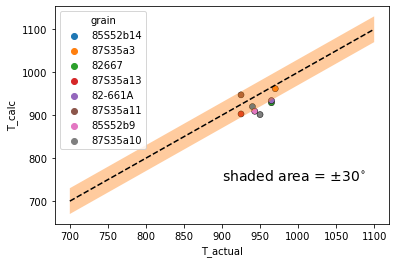

In [30]:
fig, ax = plt.subplots()
sns.scatterplot(data=T_df, x="T_actual", y="T_calc", ec="k", hue="grain", ax=ax)

x = np.linspace(700, 1100, 10)
ax.plot(x, x, "k--")
ax.fill_between(x, x + 30, x - 30, alpha=0.4)
ax.text(0.5,0.2,'shaded area = $\pm 30^{\circ}$',fontsize = 14,transform = ax.transAxes)

# Function for the whole thermometer

In [20]:
def hb_plag_amph_temp(plag_cations, amp_sites_fe, P, thermometer):
    
    """
    hb_plag_amph_temp uses the Holland and Blundy (1994) equations to calculate 
    temperatures of formation for plagioclase - amphibole pairs. 
    
    Thermometer A: for use in assemblages where plagiocalse and amphibole are 
    co crystallizing with quartz
    
    Thermometer B: for use in assemblages where plagioclase and amphibole are 
    crystallizing without quartz
    
    Inputs: 
    
    plag_cations : pandas DataFrame
    a dataframe consisting of plagioclase cation values. 
    
    amp_sites_fe : pandas DataFrame
    a dataframe consiting of ideal site assignments that includes ferric and ferrous
    iron. This is the output from the "get_amp_sites_ferric_ferrous" function and does
    not need any tweaking
    
    P : scalar
    Pressure of formation in kbar
    
    thermometer : string
    Which thermometer you would like to use: Either "A" or "B"
    
    Returns:
    
    T_df: pandas DataFrame
    dataframe of temperature calculation results for each grain in the input dataframes.
    Where there are multiple analyses per phase per grain, every possible temperature 
    will be calculated (e.g., 4 amphibole analyes and 3 plag analyses per grain/sample
    would yield 12 temperatures)
    
    
    """

    # thermodynamic parameters
    R = 0.0083144  # kJ/K
    Ab = (
        plag_cations["Na"]
        / (plag_cations["Na"] + plag_cations["Ca"] + plag_cations["K"])
    ).to_numpy()
    An = (
        plag_cations["Ca"]
        / (plag_cations["Na"] + plag_cations["Ca"] + plag_cations["K"])
    ).to_numpy()

    plag_cations["An"] = An
    plag_cations["Ab"] = Ab
    # Calculating Yab for Thermometer A
    Y = np.empty(An.shape)

    # Yab-an parameters for each thermometer
    for i in range(len(An)):
        # Calculating Yab for Thermometer A

        if thermometer == "A":

            if Ab[i] > 0.5:
                Y[i] = 0
            else:
                Y[i] = 12.01 * (1 - Ab[i]) ** 2 - 3

        elif thermometer == "B":

            # Calculating Yab-an for Thermometer B
            if Ab[i] > 0.5:
                Y[i] = 3
            else:
                Y[i] = 12.0 * (2 * Ab[i] - 1) + 3
        else:
            raise Exception(
                'This alphabet is only two letters long. Please choose "A" or "B" for your thermometer'
            )
    plag_cations["Y"] = Y
    # cummingtonite substitution

    cm = (
        amp_sites_fe["Si_T"]
        + (amp_sites_fe["Al_T"] + amp_sites_fe["Al_D"])
        + amp_sites_fe["Ti_D"]
        + amp_sites_fe["Fe3_D"]
        + (amp_sites_fe["Fe2_C"] + amp_sites_fe["Fe2_B"])
        + (amp_sites_fe["Mg_D"] + amp_sites_fe["Mg_C"])
        + amp_sites_fe["Mn_C"]
        + amp_sites_fe["Mn_B"]
        - 13
    )

    # site terms for the thermometer
    Si_T1 = (amp_sites_fe["Si_T"] - 4) / 4

    Al_T1 = (8 - amp_sites_fe["Si_T"]) / 4

    Al_M2 = (amp_sites_fe["Al_T"] + amp_sites_fe["Al_D"] + amp_sites_fe["Si_T"] - 8) / 2

    K_A = amp_sites_fe["K_A"]

    box_A = (
        3
        - amp_sites_fe["Ca_B"]
        - (amp_sites_fe["Na_B"] + amp_sites_fe["Na_A"])
        - amp_sites_fe["K_A"]
        - cm
    )

    Na_A = amp_sites_fe["Ca_B"] + amp_sites_fe["Na_B"] + amp_sites_fe["Na_A"] + cm - 2

    Na_M4 = (2 - amp_sites_fe["Ca_B"] - cm) / 2

    Ca_M4 = amp_sites_fe["Ca_B"] / 2

    hbl_plag_params = pd.DataFrame(
        {
            "Si_T1": Si_T1,
            "Al_T1": Al_T1,
            "Al_M2": Al_M2,
            "K_A": K_A,
            "box_A": box_A,
            "Na_A": Na_A,
            "Na_M4": Na_M4,
            "Ca_M4": Ca_M4,
        }
    )
    # put the index back in for the sample labels
    hbl_plag_params.index = amphs.index

    # checks for the same unique index names in your plag and amphibole dataframes
    sameset = set(hbl_plag_params.index.unique().to_list())

    samegrains = list(sameset.intersection(plag_cations.index.unique().to_list()))

    # empty list to fill with individual temperature dataframes
    T_df_list = []

    for grain in samegrains:

        # this extracts each individual grain from the respective dataframes
        # for plag and amphibole data
        amp = hbl_plag_params.loc[grain, :]
        plag = plag_cations.loc[grain, :]

        # This conditional checks how many plag analyses there are for a given grain.
        # if there is more than one it will follow the first option and use array broadcasting
        # to calculate every possible temperature for a given amphibole - plagioclase pair.
        # e.g. if you have two plag analyses and 4 amphibole analyses you will get 8 total temperatures
        if len(amp.shape) == 2:

            if len(plag.shape) == 2:
                if thermometer == "A":

                    # numerator for thermometer A
                    top = (
                        -76.95
                        + (0.79 * P)
                        + plag["Y"].to_numpy()[:, np.newaxis]
                        + 39.4 * amp["Na_A"].to_numpy()
                        + 22.4 * amp["K_A"].to_numpy()
                        + (41.5 - 2.89 * P) * amp["Al_M2"].to_numpy()
                    )
                    # denominator for thermometer A
                    bottom = -0.0650 - R * np.log(
                        (
                            27
                            * amp["box_A"].to_numpy()
                            * amp["Si_T1"].to_numpy()
                            * plag["Ab"].to_numpy()[:, np.newaxis]
                        )
                        / (256 * amp["Na_A"].to_numpy() * amp["Al_T1"].to_numpy())
                    )

                    # final thermometer A
                    T = (top / bottom) - 273.15
                elif thermometer == "B":

                    # thermometer B whole thing
                    T = (
                        (
                            78.44
                            + plag["Y"].to_numpy()[:, np.newaxis]
                            - 33.6 * amp["Na_M4"].to_numpy()
                            - (66.8 - 2.92 * P) * amp["Al_M2"].to_numpy()
                            + 78.5 * amp["Al_T1"].to_numpy()
                            + 9.4 * amp["Na_A"].to_numpy()
                        )
                        / (
                            0.0721
                            - R
                            * np.log(
                                (
                                    27
                                    * amp["Na_M4"].to_numpy()
                                    * amp["Si_T1"].to_numpy()
                                    * plag["An"].to_numpy()[:, np.newaxis]
                                )
                                / (
                                    64
                                    * amp["Ca_M4"].to_numpy()
                                    * amp["Al_T1"].to_numpy()
                                    * plag["Ab"].to_numpy()[:, np.newaxis]
                                )
                            )
                        )
                    ) - 273.15

                # making the temperatures for a given grain dataframe for ease of use later on
                T_df_list.append(
                    pd.DataFrame({"grain": grain, "T": np.concatenate(T, axis=None),})
                )

            # This is triggered if there is only one plag analysis per amphibole. In this case
            # we don't need array broadcasting because the plag An/Ab variables are scalars. All the
            # equations are the same as above

            else:
                if thermometer == "A":

                    top = (
                        -76.95
                        + (0.79 * P)
                        + plag["Y"]
                        + 39.4 * amp["Na_A"].to_numpy()
                        + 22.4 * amp["K_A"].to_numpy()
                        + (41.5 - 2.89 * P) * amp["Al_M2"].to_numpy()
                    )
                    bottom = -0.0650 - R * np.log(
                        (
                            27
                            * amp["box_A"].to_numpy()
                            * amp["Si_T1"].to_numpy()
                            * plag["Ab"]
                        )
                        / (256 * amp["Na_A"].to_numpy() * amp["Al_T1"].to_numpy())
                    )

                    T = (top / bottom) - 273.15
                elif thermometer == "B":

                    T = (
                        (
                            78.44
                            + plag["Y"]
                            - 33.6 * amp["Na_M4"].to_numpy()
                            - (66.8 - 2.92 * P) * amp["Al_M2"].to_numpy()
                            + 78.5 * amp["Al_T1"].to_numpy()
                            + 9.4 * amp["Na_A"].to_numpy()
                        )
                        / (
                            0.0721
                            - R
                            * np.log(
                                (
                                    27
                                    * amp["Na_M4"].to_numpy()
                                    * amp["Si_T1"].to_numpy()
                                    * plag["An"]
                                )
                                / (
                                    64
                                    * amp["Ca_M4"].to_numpy()
                                    * amp["Al_T1"].to_numpy()
                                    * plag["Ab"]
                                )
                            )
                        )
                    ) - 273.15

                T_df_list.append(
                    pd.DataFrame({"grain": grain, "T": np.concatenate(T, axis=None),})
                )
        # This is triggered if there is only one amphibole analysis per plag. In this case
        # we don't need array broadcasting or the .to_numpy() function because the amphibole
        # values are already scalars
        else:

            if len(plag.shape) == 2:

                if thermometer == "A":

                    # numerator for thermometer A
                    top = (
                        -76.95
                        + (0.79 * P)
                        + plag["Y"][:, np.newaxis]
                        + 39.4 * amp["Na_A"]
                        + 22.4 * amp["K_A"]
                        + (41.5 - 2.89 * P) * amp["Al_M2"]
                    )
                    # denominator for thermometer A
                    bottom = -0.0650 - R * np.log(
                        (27 * amp["box_A"] * amp["Si_T1"] * plag["Ab"][:, np.newaxis])
                        / (256 * amp["Na_A"].to_numpy() * amp["Al_T1"])
                    )

                    # final thermometer A
                    T = (top / bottom) - 273.15

                elif thermometer == "B":
                    # thermometer B whole thing
                    T = (
                        (
                            78.44
                            + plag["Y"][:, np.newaxis]
                            - 33.6 * amp["Na_M4"]
                            - (66.8 - 2.92 * P) * amp["Al_M2"]
                            + 78.5 * amp["Al_T1"]
                            + 9.4 * amp["Na_A"]
                        )
                        / (
                            0.0721
                            - R
                            * np.log(
                                (
                                    27
                                    * amp["Na_M4"]
                                    * amp["Si_T1"]
                                    * plag["An"][:, np.newaxis]
                                )
                                / (
                                    64
                                    * amp["Ca_M4"]
                                    * amp["Al_T1"]
                                    * plag["Ab"][:, np.newaxis]
                                )
                            )
                        )
                    ) - 273.15

                # making the temperatures for a given grain dataframe for ease of use later on
                T_df_list.append(
                    pd.DataFrame({"grain": grain, "T": np.concatenate(T, axis=None),})
                )

            # This is triggered if there is only one plag analysis per amphibole. In this case
            # we don't need array broadcasting because the plag An/Ab variables are scalars. All the
            # equations are the same as above

            else:
                if thermometer == "A":

                    top = (
                        -76.95
                        + (0.79 * P)
                        + plag["Y"]
                        + 39.4 * amp["Na_A"]
                        + 22.4 * amp["K_A"]
                        + (41.5 - 2.89 * P) * amp["Al_M2"]
                    )
                    bottom = -0.0650 - R * np.log(
                        (27 * amp["box_A"] * amp["Si_T1"] * plag["Ab"])
                        / (256 * amp["Na_A"] * amp["Al_T1"])
                    )

                    T = (top / bottom) - 273.15
                elif thermometer == "B":

                    T = (
                        (
                            78.44
                            + plag["Y"]
                            - 33.6 * amp["Na_M4"]
                            - (66.8 - 2.92 * P) * amp["Al_M2"]
                            + 78.5 * amp["Al_T1"]
                            + 9.4 * amp["Na_A"]
                        )
                        / (
                            0.0721
                            - R
                            * np.log(
                                (27 * amp["Na_M4"] * amp["Si_T1"] * plag["An"])
                                / (64 * amp["Ca_M4"] * amp["Al_T1"] * plag["Ab"])
                            )
                        )
                    ) - 273.15
                    

                T_df_list.append(pd.DataFrame({"grain": grain, "T_calc": [T],},))

    # overall temperature dataframe for every grain
    T_df = pd.concat(T_df_list)
    return T_df

## call the thermometer

In [31]:
# call the thermometer
hb_test_temps = hb_plag_amph_temp(plag_cations, amp_sites_fe, P=2, thermometer="B").set_index("grain")

#inputting the actual temperatures for comparison
hb_test_temps["T_actual"] = 0
for grain in samegrains:
    hb_test_temps.loc[grain, "T_actual"] = plags.loc[grain, "T_actual"]
    
hb_test_temps

,T_calc,T_actual
grain,,
85S52b14,920.003168,940
87S35a3,961.606824,970
82667,928.867424,965
87S35a13,902.858584,925
82-661A,933.909302,965
87S35a11,947.257151,925
85S52b9,909.086180,943
87S35a10,901.414380,950


In [19]:
# call the thermometer
hb_test_temps = hb_plag_amph_temp(plag_cations, amp_sites_fe, P=2, thermometer="A").set_index("grain")

#inputting the actual temperatures for comparison
hb_test_temps["T_actual"] = 0
for grain in samegrains:
    hb_test_temps.loc[grain, "T_actual"] = plags.loc[grain, "T_actual"]
    
hb_test_temps

,T_calc,T_actual
grain,,
85S52b14,1233.964228,940
87S35a3,1474.467805,970
82667,1262.604017,965
87S35a13,1139.877221,925
82-661A,1283.994010,965
87S35a11,1466.259912,925
85S52b9,1187.123763,943
87S35a10,1221.586700,950


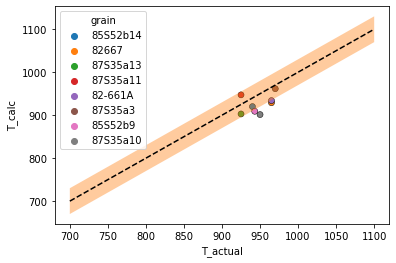

In [116]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=hb_test_temps, x="T_actual", y="T_calc", ec="k", hue="grain", ax=ax
)

x = np.linspace(700, 1100, 10)
ax.plot(x, x, "k--")
ax.fill_between(x, x + 30, x - 30, alpha=0.4)